# Hyperparameter optimization

In [118]:
np.round(np.exp(-1/960),5)

np.float64(0.99896)

In [1]:
import numpy as np
# Manually restore the alias that old Seaborn is looking for
#np.float = float
#np.int = int
#np.bool = bool

import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from utils import sety, setx, MetricExplorer, make_explorer

import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Nimbus Sans'],
    'font.size': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'lines.markersize': 4,
})

def add_lab(ax, panel_label='A',x=-0.1,y=1.05):
    ax.text(x,y, f'({panel_label})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

In [2]:
def load(window = 60,
         cohort = 'case'): # ctrl
                       
    processed_path = f'/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/{cohort}/revision_nan_all_patients_{window}.npz'
    data = np.load(processed_path,allow_pickle=True)

    print('cases',len(data['metadata']))
    
    return data    

In [4]:
# valid values here might be different from valid values in prediction! Double selection.
data = load() # 159 loaded. Minus 19 = 140. Only 115 make it.

cases 159


### Cohort selection

In [178]:
def plot_cohort(res, thres=0.9, loc='lower right',acceptance=20, title=''):

    # case
    df = pd.DataFrame(res)
    df['total_d'] = df['total']/1 # keep hours
    df['valid_d'] = df['valid']/1 # keep hours
    df['ratio'] = df['valid']/df['total']

    # compute
    
    
    accepted = df[df.valid >= 24*acceptance]
    rejected = df[df.valid < 24*acceptance]
    print('accepted:', len(accepted), 'rejected:',len(rejected), 'total:',len(df))
    
    f, ax = plt.subplots(1, 1, figsize=[5.5, 3])

    if title:
        plt.title(title)
    
    # Sort and plot
    df = df.sort_values("valid", ascending=False).reset_index(drop=True)
    
    # Create scatter plot with colorbar
    scatter = ax.scatter(df['total_d'], df['valid_d'], c=df['ratio'], 
                         cmap='viridis', vmin=0, vmax=1, s=5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Data completeness', rotation=270, labelpad=15)
    
    # Plot reference lines
    ax.plot([0, 3500], #5500, 110*24], [0, 2500, 5500, 110*24], 
            [0,3500],
            c='gray', ls='-', label='100% complete')
    if thres:
        ax.plot([0, 3500], #5500, 110*24], [0, 2500*thres, 5500*thres, 110*24*thres], 
                [0, 3500*thres],
                c='red', ls='--', label='Tuning cohort \n (≥90% complete)')
    ax.axhline(y=acceptance*24, c='blue', ls='--', 
              label='Evaluation cohort \n (≥480 valid hours)')
    
    ax.set_ylim([0, 110*24 + 0])
    
    # Labels and legend
    ax.set_xlabel('Total hours, including missing')
    ax.set_ylabel('Valid hours, excluding missing')
    ax.legend(loc=loc, fontsize=8, framealpha=1)
    
    plt.tight_layout()
    
    # Generate output
    #meta = pd.DataFrame.from_records(data['metadata'])
    #meta['pid'] = meta['patient_count']
    #df = df.merge(meta, how='left', on='pid')
    #print(df[df['ratio']>thres].pid.unique())
    
    plt.tight_layout()
    #plt.savefig('./figs/fig_S1_cohorts.pdf', dpi=300, bbox_inches="tight")
    return ax    

In [168]:
data = load()
res = [{'pid':pid, 'total':data['data'][pid][:,:,0].size, 
        'valid':(np.isnan(data['data'][pid][:,:,0])==False).sum()} for pid in range(159)]

cases 159


In [147]:
lookup = {data['metadata'][i]['patient_count']: data['metadata'][i]['patient_id'] for i in range(len(data['metadata']))}
df = pd.DataFrame.from_records(res)
df['uuid'] = df['pid'].map(lookup)
df['missing'] = df['total'] - df['valid']
##df.to_csv('case_cohort.csv')

# Print as CSV to console
print("pid,total,valid,missing,uuid")
for item in res:
    pid = item['pid']
    uuid = lookup.get(pid, '')
    missing = item['total'] - item['valid']
    print(f"{pid},{item['total']},{item['valid']},{missing},{uuid}")

pid,total,valid,missing,uuid
0,2280,1658,622,efae8744-f8d5-4b0e-8446-8afdd323e0c2
1,2280,271,2009,b0b3a018-5e53-4bdb-ac95-9e08f41e44d4
2,1800,236,1564,1c970dc5-a573-4ffe-89ed-5b424cdd96b3
3,2232,1431,801,03fcd0c3-bbb3-4388-816d-69d2f9b15510
4,2280,2154,126,4bbfa829-7a36-4752-80d4-95a1f7e31e1d
5,2256,733,1523,183b8401-c2bf-4778-a317-98f8b0322338
6,2232,1055,1177,5eb7aa55-27a5-48b1-88b6-12ff20fcdb50
7,2304,919,1385,58082b8e-d876-4554-a2b9-ce3be8b89a1e
8,2280,1436,844,9e1e7d5e-bdd4-48d0-8989-edbf63cef8e3
9,2280,2215,65,14cf26a8-aea2-4a1b-9578-508e0e9dea8c
10,2328,1822,506,43896ddd-7b38-49f6-9f17-b366fc3ea779
11,2160,348,1812,985395bb-2494-445f-99ac-ec5990177d9c
12,2424,1391,1033,a78bee88-f696-4be4-82b1-3f5369674710
13,2400,462,1938,bf2d17fe-4377-4e2d-8a8a-c883ccae88b4
14,2112,1133,979,ba4ebbe8-beb3-4df4-8e52-cb8805983b3a
15,2304,1360,944,1425284f-05b8-45d4-a514-3b8a047625b9
16,2304,1214,1090,7a7753d8-2d20-4601-8841-8ae6ce3d3155
17,2016,997,1019,7a093167-560e-4947-b460-f9ed01b5a75b
18,2304

accepted: 134 rejected: 25 total: 159


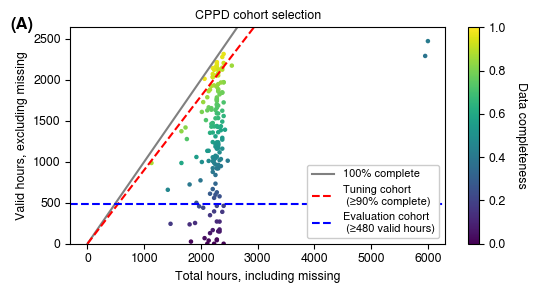

In [179]:
ax = plot_cohort(res,title='CPPD cohort selection')
add_lab(ax,'A')
plt.savefig(f'./figs/fig_S1A_case.jpg', dpi=300, bbox_inches="tight")
plt.show()
plt.close()    

In [173]:
data = load(cohort='ctrl')
res2 = [{'pid':pid, 'total':data['data'][pid][:,:,0].size, 
        'valid':(np.isnan(data['data'][pid][:,:,0])==False).sum()} for pid in range(71)]

cases 71


In [150]:
lookup = {data['metadata'][i]['patient_count']: data['metadata'][i]['patient_id'] for i in range(len(data['metadata']))}
df2 = pd.DataFrame.from_records(res2)
df2['uuid'] = df2['pid'].map(lookup)
df2['missing'] = df2['total'] - df2['valid']
##df2.to_csv('control_cohort.csv')

# Print as CSV to console
print("pid,total,valid,missing,uuid")
for item in res2:
    pid = item['pid']
    uuid = lookup.get(pid, '')
    missing = item['total'] - item['valid']
    print(f"{pid},{item['total']},{item['valid']},{missing},{uuid}")

pid,total,valid,missing,uuid
0,2352,2063,289,fda84c24-e1a0-4771-b5c3-649f182f30e9
1,2016,1628,388,a92e6e7d-3a80-4384-9dcb-5921bf1898c6
2,2256,2159,97,451c1e6c-9593-4df3-b0ad-04e16b0518be
3,2256,1433,823,eb97462e-d9e5-47f8-9c3b-fd542d86d89e
4,2304,0,2304,b64e7ef3-68d5-474c-8c6b-5ec3afb29757
5,2256,1580,676,f03bd1e9-3d01-455f-896a-1b7a086ff386
6,2064,2006,58,76f6f7d0-ca60-4476-9640-0e5e8190eb92
7,2304,1173,1131,1fa8e56a-20e6-4cc5-9f17-d77e6d6c400a
8,2376,2274,102,051f532b-2f35-4b68-85ef-fdbbf779eefc
9,912,417,495,f35659f0-f013-404e-9479-52f1ab359d1b
10,2352,690,1662,57f60bb1-8736-4f80-b552-878772930e5b
11,1944,897,1047,552adfcc-d15d-432f-87b6-a490826681df
12,2328,2191,137,c4913ae2-1f0c-4ae3-8dc6-64e42ae07663
13,2328,1542,786,06b377fc-e054-4282-83ea-ac302d509814
14,1080,805,275,e1781fd3-8cd3-4a33-8b9a-160b29eb3b95
15,1920,826,1094,3c9cfe40-f922-4bb3-9600-8cf9f71a1d37
16,1992,1760,232,8e3452ae-45af-450c-ad98-52e2f18410bf
17,1848,1598,250,0b4ab893-c11a-41e9-8696-381e46840842
18,2328,2148,18

accepted: 61 rejected: 10 total: 71


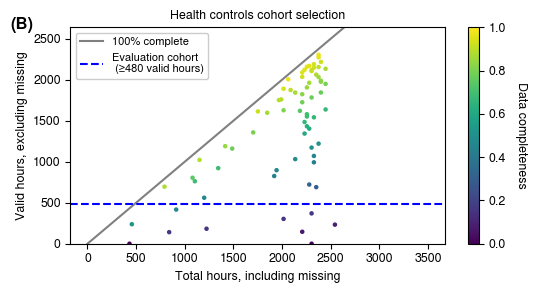

In [180]:
#ax = plot_cohort(res,title='CPPD cohort selection')
ax = plot_cohort(res2, thres=None, loc='upper left', title='Health controls cohort selection')
add_lab(ax,'B')
plt.savefig(f'./figs/fig_S1B_ctrl.jpg', dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#### Combine 

In [181]:
from PIL import Image

def combine_images(img_paths, output_path, columns=2):
    images = [Image.open(x) for x in img_paths]
    
    # Assume all images are the same size
    width, height = images[0].size
    rows = (len(images) + columns - 1) // columns
    
    combined_img = Image.new('RGB', (width * columns, height * rows), (255, 255, 255))
    
    for i, img in enumerate(images):
        x = (i % columns) * width
        y = (i // columns) * height
        combined_img.paste(img, (x, y))
        
    combined_img.save(output_path, quality=95)

# Usage:
combine_images(['./figs/fig_S1A_case.jpg', './figs/fig_S1B_ctrl.jpg'], './figs/fig_S1_combined.jpg')

## RLS Tuning

In [187]:
# Experiment 1:
run = '20251117_1351'
exp = explorer = make_explorer(run)
exp.data.group.unique()

array(['Calibration'], dtype=object)

#### Effective window size and temporal receptive fields

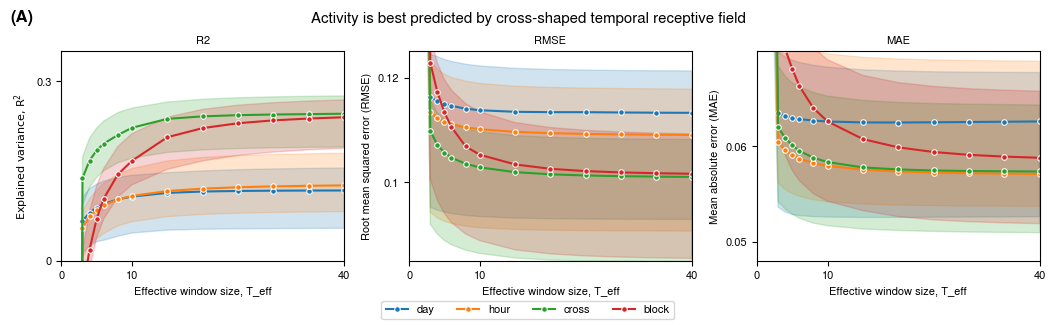

In [188]:
# ----------------------
# ACTIVITY vs T_EFF PLOT
# ----------------------

robust, suff = True, 'robust'
#robust, suff = False, ''

f, axs = explorer.plot_lines(
    hue='field',
    x='T_eff',
    fixed_conditions={
        'kernel_hour': 5, 'kernel_day': 5, 'initial_uncertainty': 5,
        'forecasting_modality': 'a|a', 'task': 'activity', 'condition': 'all'
    },
    hue_order=['day','hour','cross','block'],
    robust = robust,
    #errorbar=('se', 1)
)

# ticks and limts
sety(axs[0],[0,0.3], [0,0.35])
sety(axs[1],[0.1, 0.12], [0.085,0.125])
sety(axs[2],[0.05,0.06], [0.048,0.07])

handles, labels = axs[0].get_legend_handles_labels()

# Remove all internal legends
for ax in axs:
    setx(ax,[0,10, 40], [0,40])
    explorer.apply_nature_style(ax)
    ax.get_legend().remove()
    ax.set_xlabel('Effective window size, T_eff')
    #ax.set_title('')
    
axs[0].set_ylabel(r'Explained variance, $R^2$')
axs[1].set_ylabel(r'Root mean squared error (RMSE)')
axs[2].set_ylabel(r'Mean absolute error (MAE)')

# Place single bottom legend
f.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=8)
f.subplots_adjust(bottom=0.2)  # space for legend

# Optional super-title
f.suptitle('Activity is best predicted by cross-shaped temporal receptive field', y=1.03)

# label
add_lab(axs[0],'A', y=1.2)

explorer.save_figure(f, f'./figs/fig_RLS_{suff}_Teff.jpg', timestamp=False)

#explorer.save_figure(f, './figs/fig3a_calib_field.pdf')

#plt.tight_layout()

plt.show()
plt.close()

#### ACTIVITY vs P0 PLOT

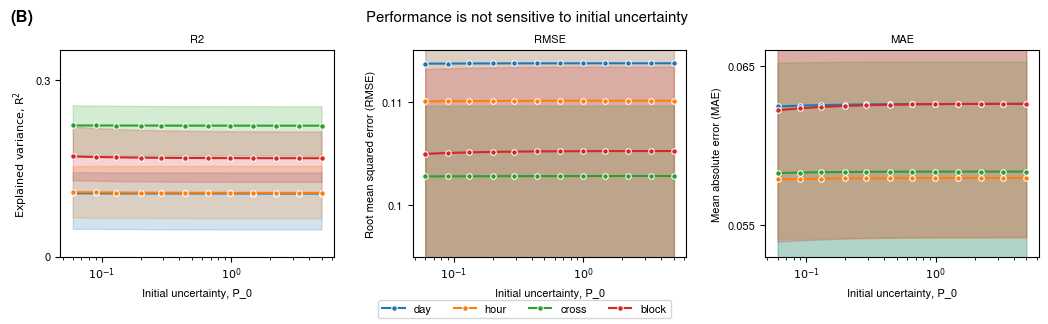

In [189]:
# ----------------------
# ACTIVITY vs P0 PLOT
# ----------------------

# activity
f,axs=explorer.plot_lines(
        hue='field',
        x='initial_uncertainty',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'T_eff':10,
                          'forecasting_modality': 'a|a', 
                          'task':'activity', 'condition':'all'},
        hue_order=['day','hour','cross','block'],
        robust=robust,
        #errorbar=('se', 1)
)
for ax in axs:
    ax.set_xscale('log')    

f.suptitle('Performance is not sensitive to initial uncertainty', y=1.03)

# ticks and limts
sety(axs[0],[0,0.3], [0,0.35])
sety(axs[1],[0.1, 0.11], [0.095,0.115])
sety(axs[2],[0.055,0.065], [0.053,0.066])

# Extract handles and labels from first axis
handles, labels = axs[0].get_legend_handles_labels()

# Remove all internal legends
for ax in axs:
    explorer.apply_nature_style(ax)
    ax.get_legend().remove()
    ax.set_xlabel('Initial uncertainty, P_0')
    #ax.set_title('')
    
axs[0].set_ylabel(r'Explained variance, $R^2$')
axs[1].set_ylabel(r'Root mean squared error (RMSE)')
axs[2].set_ylabel(r'Mean absolute error (MAE)')

# Place single bottom legend
f.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=8)
f.subplots_adjust(bottom=0.21)  # space for legend

#explorer.save_figure(f, './figs/fig3b_calib_P0_Teff_10.pdf')
add_lab(axs[0],'B', y=1.2)

explorer.save_figure(f, f'./figs/fig_RLS_{suff}_P0.jpg', timestamp=False)

#plt.tight_layout()

plt.show()
plt.close()

#### Different inputs

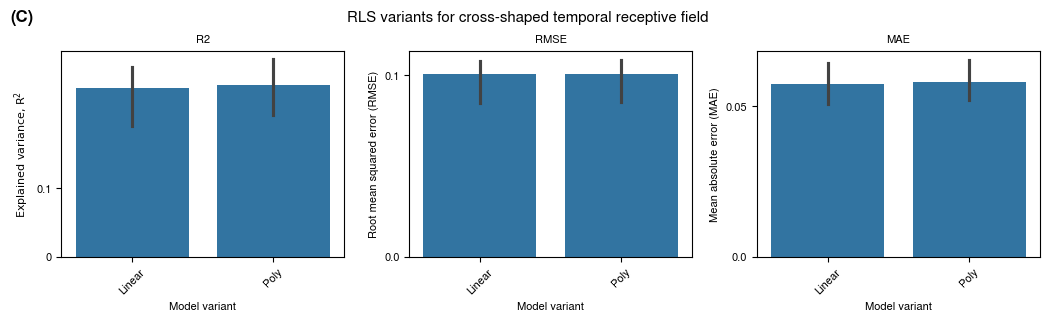


Summary Statistics (Robust: Median/IQR):


R2          RMSE           MAE       
             Median    IQR Median    IQR Median    IQR
model_config                                          
Linear        0.246  0.086  0.101  0.023  0.057  0.013
Poly          0.249  0.081  0.101  0.023  0.058  0.013

In [32]:
run = '20251117_1447' # redo with 47, original with 20251117_1440
explorer = exp = make_explorer(run)
plot = True
robust = True  # Toggle this to False for Mean/SE

def fmt(diag, poly, logit):
    return (
        #("Diag" if diag else "Full") + "_" +        
        ("Poly" if poly else "Linear") #+ "_" +
        #("Logit" if logit else "Gauss")
    )

# remove logit, remove inputs, remove diag
explorer.data = explorer.data[explorer.data.use_logit_space==False]
explorer.data = explorer.data[explorer.data.diagonal_covariance==False]
explorer.data = explorer.data[explorer.data.forecasting_modality.isin(['a|a'])] # 'ah|ah']

explorer.data["model_config"] = [
    fmt(d, p, l)
    for d, p, l in zip(
        explorer.data["diagonal_covariance"],
        explorer.data["use_polynomial"],
        explorer.data["use_logit_space"]
    )
]

# --- PARAMETERS ---
x_var = 'model_config'
#hue_var ='field' # None # Set this if you want to split bars by another category
fixed = {
    'field': 'cross', 
    'initial_uncertainty': 5, 
    'T_eff': 40, 
    'condition': 'all',
    'kernel_hour': 5, 
    'kernel_day': 5,
    'task': 'activity'
}

# --- STATS LOGIC ---
if robust:
    stats_kwargs = {
        'estimator': np.median,
        'errorbar': ('pi', 50)  # 50th percentile interval = IQR
    }
else:
    stats_kwargs = {
        'estimator': np.mean,
        'errorbar': ('se', 1)
    }

# --- EXECUTION ---
df_plot = explorer.filter(**fixed)

fig, axes = plt.subplots(1, explorer.cols, figsize=(explorer.col_width * explorer.cols, explorer.row_height))

# Ensure axes is a list even if only 1 metric
if explorer.cols == 1:
    axes = [axes]

for ax, metric in zip(axes, explorer.metrics):
    sns.barplot(
        data=df_plot, 
        x=x_var, 
        y=metric, 
        #hue=hue_var, 
        ax=ax, 
        **stats_kwargs,
        #palette='viridis' # Optional: makes it look cleaner
    )
    
    ax.set_title(f'{metric.upper()}')
    
    # Rotate x-labels if 'model_config' names are long
    ax.tick_params(axis='x', rotation=45)
    
    if metric == 'r2':
        ax.set_ylim([-0.1, 1])

plt.tight_layout()
f, axs = fig, axes  # Match your variable naming preference


##### now that we have the best model

f.suptitle('RLS variants for cross-shaped temporal receptive field', y=1.03)

# ticks and limts
sety(axs[0],[0,0.1], [0,0.3]) #, [0,0.4])
sety(axs[1],[0., 0.1]) #[0.095,0.115])
sety(axs[2],[0.,0.05]) #, [0.053,0.066])

# Extract handles and labels from first axis
handles, labels = axs[0].get_legend_handles_labels()

# Remove all internal legends
for ax in axs:
    explorer.apply_nature_style(ax)
    #ax.get_legend().remove()
    ax.set_xlabel('Model variant')
    #ax.set_title('')
    
axs[0].set_ylabel(r'Explained variance, $R^2$')
axs[1].set_ylabel(r'Root mean squared error (RMSE)')
axs[2].set_ylabel(r'Mean absolute error (MAE)')

# Place single bottom legend
#f.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=8)
f.subplots_adjust(bottom=0.21)  # space for legend

#explorer.save_figure(f, './figs/fig3b_calib_P0_Teff_10.pdf')
add_lab(axs[0],'C', y=1.2)

if plot:
    explorer.save_figure(f, f'./figs/fig_RLS_inputs_{suff}.jpg', timestamp=False)

#plt.tight_layout()

plt.show()
plt.close()

# --- GENERATE SUMMARY TABLE ---
agg_results = []

for metric in explorer.metrics:
    if robust:
        # Calculate Median, Q1, Q3, and IQR
        stats = df_plot.groupby(x_var)[metric].agg([
            ('Median', 'median'),
            ('Q1', lambda x: x.quantile(0.25)),
            ('Q3', lambda x: x.quantile(0.75))
        ])
        stats['IQR'] = stats['Q3'] - stats['Q1']
        # Keep only Median and IQR for the final display
        res = stats[['Median', 'IQR']]
    else:
        # Calculate Mean and Standard Error
        stats = df_plot.groupby(x_var)[metric].agg([
            ('Mean', 'mean'),
            ('StdError', lambda x: x.std() / np.sqrt(len(x)))
        ])
        res = stats

    # Multi-index columns to keep track of which metric is which
    res.columns = pd.MultiIndex.from_product([[metric.upper()], res.columns])
    agg_results.append(res)

# Concatenate all metrics into one horizontal table
summary_table = pd.concat(agg_results, axis=1)

print(f"\nSummary Statistics ({'Robust: Median/IQR' if robust else 'Standard: Mean/SE'}):")
display(summary_table.round(3)) # use print() if not in a notebook

In [199]:
display(summary_table.round(3)) # use print() if not in a notebook

R2          RMSE           MAE       
             Median    IQR Median    IQR Median    IQR
model_config                                          
Diag_Linear   0.167  0.127  0.108  0.029  0.059  0.015
Diag_Poly     0.151  0.148  0.109  0.030  0.063  0.018
Full_Linear   0.174  0.131  0.107  0.029  0.058  0.014
Full_Poly     0.185  0.113  0.107  0.029  0.059  0.015

#### Kernel sizes:

In [3]:
run = '20251117_1442'
exp = explorer = make_explorer(run)
exp.data = exp.data[exp.data.kernel_day<=7]

AttributeError: 'DataFrame' object has no attribute 'diag'

In [17]:
#exp.data.use_polynomial.unique()
#exp.data[exp.data.diagonal_covariance==False]

array([False])

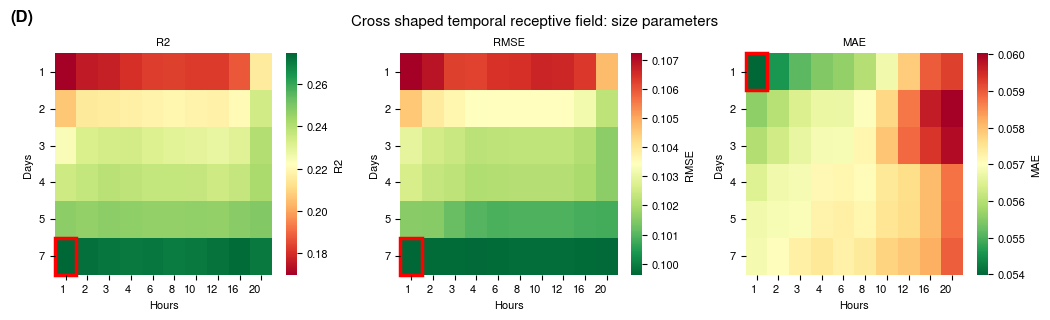

In [18]:
robust = True
aggfunc,suff = ('median','robust') if robust else ('mean','')
    
fixed_conditions={'field':'cross', 
                          'condition':'all',
                          'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity', 
                          #'kernel_day':5 ,
                          'initial_uncertainty':5, 
                          'T_eff':40,
                          'forecasting_modality':'a|a'
                         }
df = exp.filter(**fixed_conditions)
df['kernel_hour'] = df.kernel_hour.astype(int)

panel_start = None # 0 = A

# Create heatmap
fig, axs = plt.subplots(1,3,figsize=(3.5*3, 3))


for i, (ylabel,ax) in enumerate(zip(['r2','rmse','mae'],axs)):
    
    cmap = 'RdYlGn' if ylabel == 'r2' else 'RdYlGn_r'
    
    pivot = df.pivot_table(values=ylabel, index='kernel_day', columns='kernel_hour', aggfunc=aggfunc)
    hm = sns.heatmap(pivot, cmap=cmap, annot=False, cbar_kws={'label': ylabel.upper()}, ax=ax)

    # Find location of best value    
    if ylabel in ['rmse', 'mae']:        
        best_val = pivot.min().min() # Lower is better
    else:  # r2, corr        
        best_val = pivot.max().max() # Higher is better
    
    best_loc = np.where(pivot.values == best_val)
    if len(best_loc[0]) > 0:
        # Convert to row/col indices
        best_row = best_loc[0][0]
        best_col = best_loc[1][0]
        
        # Draw red rectangle around best cell
        # Heatmap cells are 1x1 starting from (col, row)
        ax.add_patch(plt.Rectangle(
            (best_col, best_row), 1, 1,
            fill=False, edgecolor='red', linewidth=2.5, clip_on=False
        ))
    

    # Add panel enumeration (A, B, C, ...)
    if panel_start is not None:
        panel_label = chr(65 + panel_start + i)  # 65 is ASCII for 'A'
        axs[i].text(-0.1, 1.05, f'({panel_label})', transform=axs[i].transAxes,
                   fontsize=12, fontweight='bold', va='top', ha='right')

    
    # Force all ticks to show
    ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
    ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
    ax.set_xticklabels(pivot.columns, rotation=0, ha='right')
    ax.set_yticklabels(pivot.index, rotation=0)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Days')
    ax.set_title(f'{ylabel.upper()}')
    exp.apply_nature_style(ax, hm)
plt.tight_layout()

fig.suptitle('Cross shaped temporal receptive field: size parameters',y=1.03)
add_lab(axs[0],'D', y=1.2)

#explorer.save_figure(f, './figs/fig3d_calib_kernels_Teff_10.pdf')
#explorer.save_figure(fig, f'./figs/fig_RLS_{suff}_shapes.jpg', timestamp=False)

#### Combine

In [34]:
import os
from PIL import Image

def stack_rows_vertical(img_paths, output_path):
    # Load images and filter out any missing files
    images = [Image.open(x) for x in img_paths if os.path.exists(x)]
    
    if not images:
        print("No images found!")
        return

    # Assume we want the width of the widest image
    # and we sum the heights
    max_width = max(img.size[0] for img in images)
    total_height = sum(img.size[1] for img in images)

    # Create the canvas (White background)
    combined_img = Image.new('RGB', (max_width, total_height), (255, 255, 255))

    # Paste them one after another
    current_y = 0
    for img in images:
        # If widths differ, this centers the image
        x_offset = (max_width - img.size[0]) // 2
        combined_img.paste(img, (x_offset, current_y))
        current_y += img.size[1]

    # Save with high quality
    combined_img.save(output_path, quality=95, subsampling=0)
    print(f"Combined image saved to: {output_path}")

# List your files in the order you want them (Top to Bottom)
files_to_combine = [    
    './figs/fig_RLS_robust_Teff_.jpg',
    './figs/fig_RLS_robust_P0_.jpg',
    './figs/fig_RLS_inputs_robust__2.jpg',    
    './figs/fig_RLS_robust_shapes__2.jpg'
]

stack_rows_vertical(files_to_combine, './figs/combined_fig_S7_RLS.jpg')

Combined image saved to: ./figs/combined_fig_S7_RLS.jpg


In [33]:
!ls figs

combined_fig_S7_RLS.jpg			  rnn_tuning_row0robust__1.jpg
fig3b_RLS_inputs_.jpg			  rnn_tuning_row0robust__2.jpg
fig3d_calib_kernels_Teff_10robust__2.jpg  rnn_tuning_row0robust__3.jpg
fig_RLS_inputs_robust__0.jpg		  rnn_tuning_row0robust__4.jpg
fig_RLS_inputs_robust__1.jpg		  rnn_tuning_row0robust__5.jpg
fig_RLS_inputs_robust__2.jpg		  rnn_tuning_row0robust__6.jpg
fig_RLS_inputs_robust_.jpg		  rnn_tuning_row0robust_.jpg
fig_RLS_robust_P0_.jpg			  rnn_tuning_row1robust__0.jpg
fig_RLS_robust_shapes__0.jpg		  rnn_tuning_row1robust__1.jpg
fig_RLS_robust_shapes__1.jpg		  rnn_tuning_row1robust__2.jpg
fig_RLS_robust_shapes__2.jpg		  rnn_tuning_row1robust__3.jpg
fig_RLS_robust_shapes_.jpg		  rnn_tuning_row1robust__4.jpg
fig_RLS_robust_Teff_.jpg		  rnn_tuning_row1robust__5.jpg
fig_S1A_case.jpg			  rnn_tuning_row1robust__6.jpg
fig_S1B_ctrl.jpg			  rnn_tuning_row1robust_.jpg
fig_S1_cohort_thres0.9.jpg		  rnn_tuning_row2robust__0.jpg
fig_S1_cohort_thresNone.jpg		  rnn_tuning_row2robust__1.jpg
fig_S

## SARIMA 

/tmp/ipykernel_2895456/1693666649.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


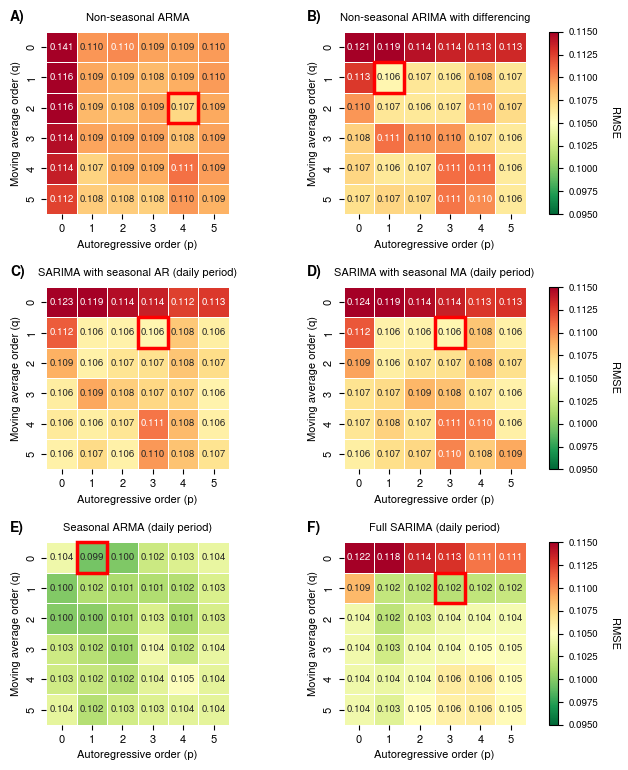

'./figs/fig_SARIMA_robust__0.jpg'

In [222]:
"""
p (6): [0, 1, 2, 3, 4, 5]
q (6): [0, 1, 2, 3, 4, 5]

d (2): [0, 1] x 2
P (2): [0, 1] x 2 
D (1): [0]  
Q (2): [0, 1] x 2
m (3): [0, 24] x 2
"""
exp = explorer = make_explorer('20251127_1822')

def get_tab(d=0, P=0, D=0, Q=0, m=0, metric='rmse',robust=False):

    aggfunc = 'median' if robust else 'mean'
    
    fix = {    
        'condition': 'all',
        'group': 'Calibration',
        'task': 'activity',        
        'forecasting_modality': 'a|a'
    }
    
    df = exp.filter(**fix)
    df = df[(df['d']==d) & (df['P']==P) & (df['D']==D) & (df['Q']==Q) & (df['m']==m)]
    return df.pivot_table(values=metric, index='q', columns='p', aggfunc=aggfunc)

# Configuration
metric = 'rmse'
cmap = 'RdYlGn' if metric == 'r2' else 'RdYlGn_r'
vmin = 0.095
vmax = 0.115
n_cols = 2
n_rows = 3
add_labels = True  # Set to False to remove A), B), etc.
robust = True

# Create figure with gridspec - add extra space for colorbars
fig = plt.figure(figsize=[3.5*n_cols + 0.5, 3*n_rows])
gs = fig.add_gridspec(n_rows, n_cols, wspace=0.25, hspace=0.4, 
                     left=0.1, right=0.88)  # Reserve space on right for colorbars

# Create all axes
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(n_cols)] for i in range(n_rows)])
axs_flat = axs.flatten()

# Define subplot configurations
configs = [
    {'d': 0, 'P': 0, 'Q': 0, 'm': 0, 
     'title': 'Non-seasonal ARMA'},
    {'d': 1, 'P': 0, 'Q': 0, 'm': 0, 
     'title': 'Non-seasonal ARIMA with differencing'},
    {'d': 1, 'P': 1, 'Q': 0, 'm': 24, 
     'title': 'SARIMA with seasonal AR (daily period)'},
    {'d': 1, 'P': 0, 'Q': 1, 'm': 24, 
     'title': 'SARIMA with seasonal MA (daily period)'},
    {'d': 0, 'P': 1, 'Q': 1, 'm': 24, 
     'title': 'Seasonal ARMA (daily period)'},
    {'d': 1, 'P': 1, 'Q': 1, 'm': 24, 
     'title': 'Full SARIMA (daily period)'}]

for c in configs:
    c.update(
     {'xlabel': 'Autoregressive order (p)',
     'ylabel': 'Moving average order (q)'})
    
# Plot each heatmap
subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']

for idx, config in enumerate(configs):
    ax = axs_flat[idx]
    
    # Get data and plot
    pivot = get_tab(d=config['d'], P=config['P'], D=0, Q=config['Q'], m=config['m'], metric=metric, robust=robust)
    sns.heatmap(pivot, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                annot=True, fmt='.3f', cbar=False,
                square=True, linewidths=0.5, annot_kws={'fontsize': 7})
    
    # Find best parameter combination
    if metric in ['rmse', 'mae']:
        # Lower is better
        best_val = pivot.min().min()
    else:  # r2, corr
        # Higher is better
        best_val = pivot.max().max()
    
    # Find location of best value
    best_loc = np.where(pivot.values == best_val)
    if len(best_loc[0]) > 0:
        # Convert to row/col indices
        best_row = best_loc[0][0]
        best_col = best_loc[1][0]
        
        # Draw red rectangle around best cell
        # Heatmap cells are 1x1 starting from (col, row)
        ax.add_patch(plt.Rectangle(
            (best_col, best_row), 1, 1,
            fill=False, edgecolor='red', linewidth=2.5, clip_on=False
        ))
    
    # Formatting  
    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel(config['ylabel'])    
    
    # Add subplot label in title (avoids overlay)    
    if add_labels:
        ax.text(-0.2, 1.12, f'{subplot_labels[idx]})', 
                transform=ax.transAxes, fontsize=10, fontweight='bold',
                va='top', ha='left')
        
    ax.set_title(config['title'], pad=8)
    
    # Apply nature style
    exp.apply_nature_style(ax)

# Add one colorbar per row (on the right side)
for row_idx in range(n_rows): 
    # Get the two axes in this row
    row_axes = [axs[row_idx, 0], axs[row_idx, 1]]
    
    # Create colorbar positioned to the right of this row
    cbar = fig.colorbar(row_axes[0].collections[0], ax=row_axes, 
                       fraction=0.046, pad=0.04)
    cbar.set_label(metric.upper(), rotation=270, labelpad=15)
    
    # Apply nature style to colorbar
    cbar.ax.tick_params(labelsize=7)
    for label in cbar.ax.get_yticklabels():
        label.set_fontsize(7)
    cbar.ax.yaxis.label.set_fontsize(8)

plt.tight_layout()
plt.show()

explorer.save_figure(fig, f'./figs/fig_SARIMA_{suff}.jpg', timestamp=False)

## Neuronal nets

In [204]:
import glob
import tqdm
#from evaluation import evaluate_run
import warnings

# 20251121_1217 <-- rnn baselines: still need metrics

# Experiment 1:
run = '20251121_1217'
explorer = make_explorer(run, metrics=['r2','rmse','mae'])
explorer.data = explorer.data[explorer.data.dt == 60]

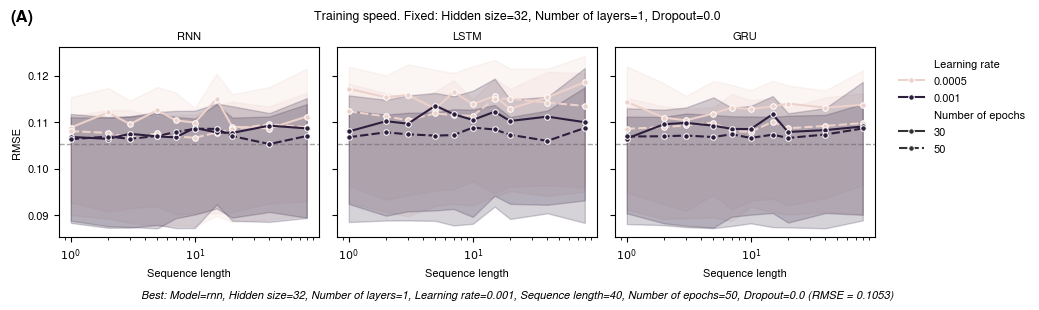

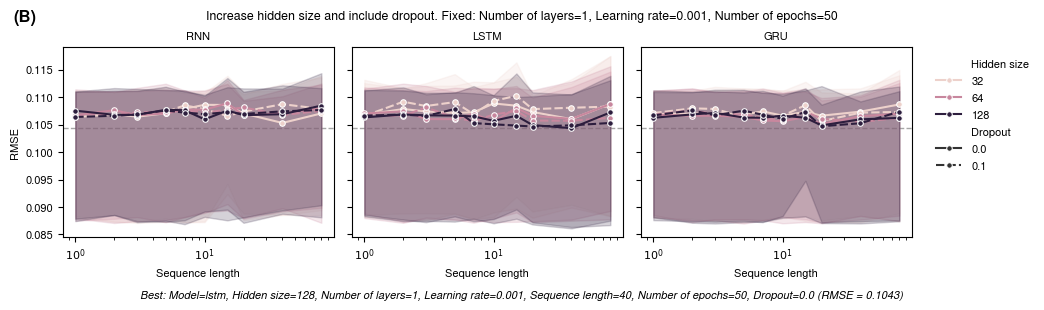

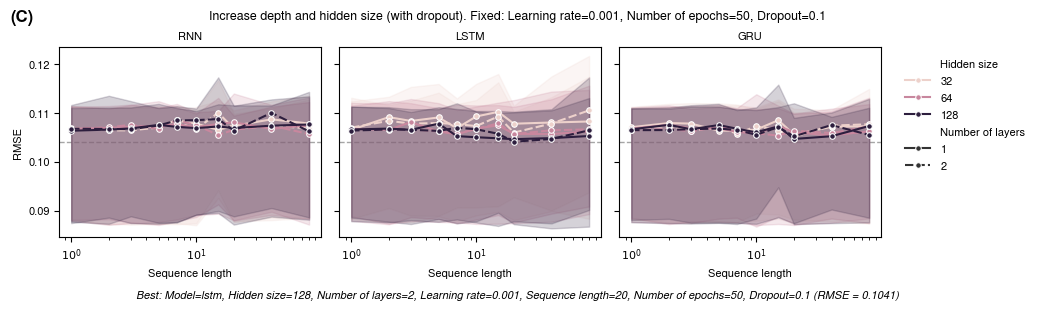

In [219]:
robust=True

# Configuration for each analysis
ANALYSES = [
    {
        'title': 'Training speed',
        'fixed': {
            'task': 'activity',
            'condition': 'all',
            'a_hidden_size': 32,
            'a_num_layers': 1,
            'a_dropout': 0.0
        },
        'hue': 'a_learning_rate',
        'style': 'a_n_epochs'
    },
    {
        'title': 'Increase hidden size and include dropout',
        'fixed': {
            'task': 'activity',
            'condition': 'all',
            'a_num_layers': 1,
            'a_learning_rate': 0.001,
            'a_n_epochs': 50
        },
        'hue': 'a_hidden_size',
        'style': 'a_dropout'
    },
    {
        'title': 'Increase depth and hidden size (with dropout)',
        'fixed': {
            'task': 'activity',
            'condition': 'all',
            'a_learning_rate': 0.001,
            'a_n_epochs': 50,
            'a_dropout': 0.1
        },
        'hue': 'a_hidden_size',
        'style': 'a_num_layers'
    }
]

# Label mapping for cleaner axis labels
LABEL_MAP = {
    'a_hidden_size': 'Hidden size',
    'a_num_layers': 'Number of layers',
    'a_learning_rate': 'Learning rate',
    'a_seq_length': 'Sequence length',
    'a_n_epochs': 'Number of epochs',
    'a_dropout': 'Dropout',
    'rmse': 'RMSE',
    'model_name': 'Model'
}

MODEL_NAMES = ['rnn', 'lstm', 'gru']
FIGURE_SIZE = (3.5 * 3, 3)  # Nature style: 3.5" per subplot


def plot_analysis(explorer, fixed_params, hue_var, style_var, title, panel_start=None, robust=False):
    """Create a 3-panel plot for RNN, LSTM, and GRU models."""
    df = explorer.filter(**fixed_params)
    
    # 1. Update reference line calculation
    agg_func = 'median' if robust else 'mean'
    grouped = df.groupby(['model_name', 'a_hidden_size', 'a_num_layers', 
                          'a_learning_rate', 'a_seq_length', 'a_n_epochs', 
                          'a_dropout'])['rmse'].agg(agg_func)
    
    best_idx = grouped.idxmin()
    best_rmse = grouped.min()

    # Create best params string (excluding varying parameters)
    best_params_dict = {
        'model_name': best_idx[0],
        'a_hidden_size': best_idx[1],
        'a_num_layers': best_idx[2],
        'a_learning_rate': best_idx[3],
        'a_seq_length': best_idx[4],
        'a_n_epochs': best_idx[5],
        'a_dropout': best_idx[6]
    }
    best_params_str = ', '.join([f'{LABEL_MAP.get(k, k)}={v}' 
                                 for k, v in best_params_dict.items()])

    fig, axs = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharey=True)    

    # Create fixed parameters annotation
    fixed_str = ', '.join([f'{LABEL_MAP.get(k, k)}={v}' 
                          for k, v in fixed_params.items() 
                          if k not in ['task', 'condition']])    
        
    # 2. Define plotting stats    
    stats = {
        'estimator': 'median',
        'errorbar': ('pi', 50)
    } if robust else {
        'estimator': 'mean',
        'errorbar': ('se', 1)
    }

    for i, model in enumerate(MODEL_NAMES):
        model_df = df[df.model_name == model]        
        
        sns.lineplot(
            data=model_df,
            x='a_seq_length',
            y='rmse',
            hue=hue_var,
            style=style_var,
            ax=axs[i],
            marker='o',
            **stats
        )            
                
        # Add horizontal reference line (per row)
        axs[i].axhline(y=best_rmse, color='gray', linestyle='--', 
                      linewidth=1, alpha=0.7, zorder=0)
        
        axs[i].set_xscale('log')
        axs[i].set_title(f'{model.upper()}')
        axs[i].set_xlabel(LABEL_MAP['a_seq_length'])
        axs[i].set_ylabel(LABEL_MAP['rmse'] if i == 0 else '')
        
        # Add panel enumeration (A, B, C, ...)
        if panel_start is not None:
            panel_label = chr(65 + panel_start + i)  # 65 is ASCII for 'A'
            axs[i].text(-0.1, 1.05, f'({panel_label})', transform=axs[i].transAxes,
                       fontsize=12, fontweight='bold', va='top', ha='right')
        
        # Fix legend labels properly
        handles, labels = axs[i].get_legend_handles_labels()
        
        # Replace variable names in legend with proper labels
        new_labels = []
        for label in labels:
            # Check if it's a variable name (title)
            if label in LABEL_MAP:
                new_labels.append(LABEL_MAP[label])
            else:
                new_labels.append(label)
        
        # Move legend to the right, one per row
        if i == 2:  # Only show legend on rightmost plot
            legend = axs[i].legend(handles, new_labels, bbox_to_anchor=(1.05, 1), 
                                  loc='upper left', frameon=False)
        else:
            axs[i].legend().remove()
        
        explorer.apply_nature_style(axs[i])
    
    # Add fixed parameters and reference info as subtitle
    fig.suptitle(f'{title}. Fixed: {fixed_str}', y=0.94, fontsize=9)
    fig.text(0.5, -0.02, f'Best: {best_params_str} (RMSE = {best_rmse:.4f})', 
             ha='center', fontsize=8, style='italic')
    plt.tight_layout()
    
    return fig, axs

# Generate all plots
labs = ['A','B','C','D']
for i,(analysis, lab) in enumerate(zip(ANALYSES, labs)):
    fig, axs = plot_analysis(
        explorer,
        analysis['fixed'],
        analysis['hue'],
        analysis['style'],
        analysis['title'],
        #panel_start=int(3*i),
        robust=robust,
    )

    add_lab(axs[0],lab, y=1.2)
    
    #explorer.save_figure(fig, f'./figs/rnn_tuning_row{i}.pdf')
    explorer.save_figure(fig, f'./figs/rnn_tuning_row{i}{suff}.jpg', timestamp=False)
    plt.show()
    plt.close()

##### Combine

In [220]:
!ls figs

combined_fig_S7_RLS.jpg			  rnn_tuning_row0robust__3.jpg
fig3b_RLS_inputs_.jpg			  rnn_tuning_row0robust__4.jpg
fig3d_calib_kernels_Teff_10robust__2.jpg  rnn_tuning_row0robust__5.jpg
fig_RLS_inputs_robust_.jpg		  rnn_tuning_row0robust__6.jpg
fig_RLS_robust_P0_.jpg			  rnn_tuning_row0robust_.jpg
fig_RLS_robust_shapes__0.jpg		  rnn_tuning_row1robust__0.jpg
fig_RLS_robust_shapes__1.jpg		  rnn_tuning_row1robust__1.jpg
fig_RLS_robust_shapes__2.jpg		  rnn_tuning_row1robust__2.jpg
fig_RLS_robust_shapes_.jpg		  rnn_tuning_row1robust__3.jpg
fig_RLS_robust_Teff_.jpg		  rnn_tuning_row1robust__4.jpg
fig_S1A_case.jpg			  rnn_tuning_row1robust__5.jpg
fig_S1B_ctrl.jpg			  rnn_tuning_row1robust__6.jpg
fig_S1_cohort_thres0.9.jpg		  rnn_tuning_row1robust_.jpg
fig_S1_cohort_thresNone.jpg		  rnn_tuning_row2robust__0.jpg
fig_S1_combined.jpg			  rnn_tuning_row2robust__1.jpg
figS3a_calib_fieldrobust__2.jpg		  rnn_tuning_row2robust__2.jpg
fig_S4_calib_P0_Teff_10robust_.jpg	  rnn_tuning_row2robust__3.jpg
fig_S

In [221]:
figs = ['./figs/' + f for f in ['rnn_tuning_row0robust__6.jpg','rnn_tuning_row1robust__6.jpg','rnn_tuning_row2robust__6.jpg']]
stack_rows_vertical(figs,output_path='./figs/rnns.jpg')

Combined image saved to: ./figs/rnns.jpg


In [78]:
file_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/best_configs.csv'
df = pd.read_csv(file_path)

# 1. Grab a template row (the first LSTM row found)
# This ensures we have all columns, even those not in your dict
template_row = df[df['model_name'] == 'lstm'].iloc[0].copy()

# 2. Define the modifications
updates = {
    'hidden_size': 128.0,
    'num_layers': 2.0,
    'learning_rate': 0.001,
    'seq_length_min': 1200.0, # 20h * 60min
    'n_epochs': 50.0,
    'dropout': 0.1,
    'batch_size': 32.0,
    'window': 60,
    'forecasting_modality': 'a|a'
}

# 3. Create and modify the new rows
new_rows = []
for cohort in ['validation', 'ctrl']:
    new_row = template_row.copy()
    # Apply all updates from the dictionary
    for key, value in updates.items():
        new_row[key] = value
    # Set the specific cohort
    new_row['patient_id'] = cohort
    new_rows.append(new_row)

# 4. Append and save
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

# Save back to CSV
#idx = list(range(8)) + [10,11]
#df = df.iloc[idx].reset_index()
#df.to_csv(file_path, index=False)

print("Rows added successfully. Total rows:", len(df))

Rows added successfully. Total rows: 12


In [ ]:
# lstm: hidden=128, layer=2, lr=0.001, seq_len=20, epoch=50, drop=0.1

# Temporal Receptive Fields

/tmp/ipykernel_492489/2264513238.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


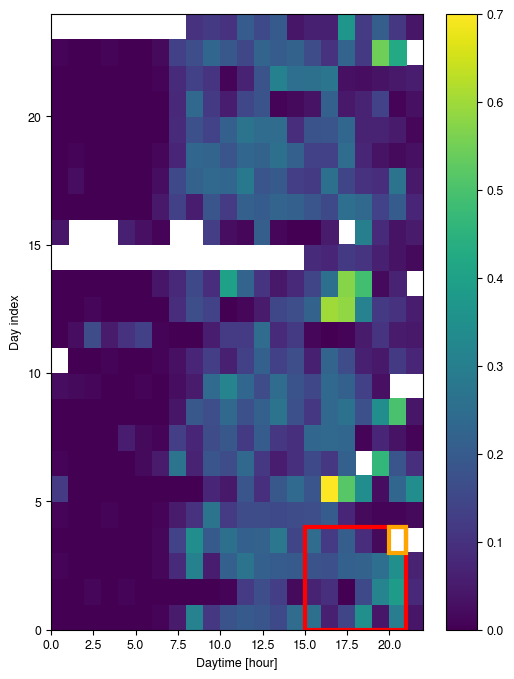

In [109]:
RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_activity_60.csv')
#plt.plot(df.iloc[:,2:].isna().mean(axis=1).sort_values().iloc[::-1].values)
#plt.title('ratio of nans per day')
idx = df.isna().mean(axis=1) < 0.7
df = df[idx].iloc[:,2:]
plt.figure(figsize=[6,8])
yy = 503
plt.pcolor(df.iloc[yy:yy+24,2:].values) # ignore index
plt.xlabel('Daytime [hour]')
plt.ylabel('Day index')
plt.colorbar()
t = 15
kh = 5
kd = 3
d = 0
rect = patches.Rectangle((t, d), kh+1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
target = patches.Rectangle((t+kh, d+kd), 1, 1, linewidth=3, edgecolor='orange', facecolor='none')
# Add the rectangle to the plot
plt.gca().add_patch(rect)
plt.gca().add_patch(target)

/tmp/ipykernel_1210018/256331088.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar on right


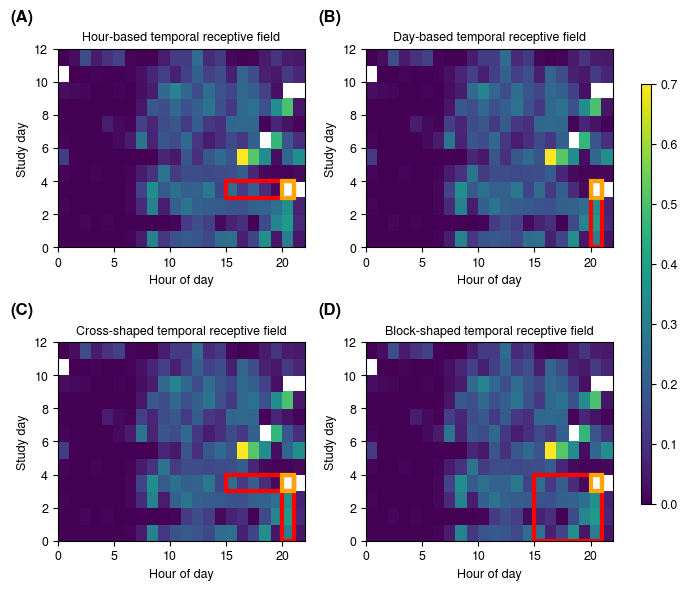

In [107]:
# Load data
RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_activity_60.csv')

# Filter and slice
idx = df.isna().mean(axis=1) < 0.7
df = df[idx].iloc[:, 2:]

# Set plot parameters
yy = 503
height = 12
data = df.iloc[yy:yy+height, 2:].values

# Rectangle parameters
t = 15
kh = 5
kd = 3
d = 0

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(3.5*2, 3*2))

labels = ['A','B','C','D']
for i, ax in enumerate(axes.flat):
    im = ax.pcolor(data)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Study day')

    add_lab(ax,labels[i],y=1.2)
    
    # Add patches
    if i == 0:
        rect = patches.Rectangle((t, d+kd), kh+1, 1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Hour-based temporal receptive field')
    elif i == 1:
        rect = patches.Rectangle((t+kh, d), 1, kd+1, linewidth=3, edgecolor='red', facecolor='none')        
        ax.set_title('Day-based temporal receptive field')
    elif i == 2:
        rect = patches.Rectangle((t+kh, d), 1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        rect = patches.Rectangle((t, d+kd), kh+1, 1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Cross-shaped temporal receptive field')
    elif i == 3:
        rect = patches.Rectangle((t, d), kh+1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Block-shaped temporal receptive field')
    ax.add_patch(rect)

    target = patches.Rectangle((t+kh, d+kd), 1, 1, linewidth=3, edgecolor='orange', facecolor='none')
    ax.add_patch(target)

# Add colorbar to the right side
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar on right

plt.savefig('./figs/temporal_receptive_fields.jpg', dpi=300)
plt.show()

# Preprocessing

In [112]:
RESULTS_PATH = "/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/"
window = 1
#df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")
df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")

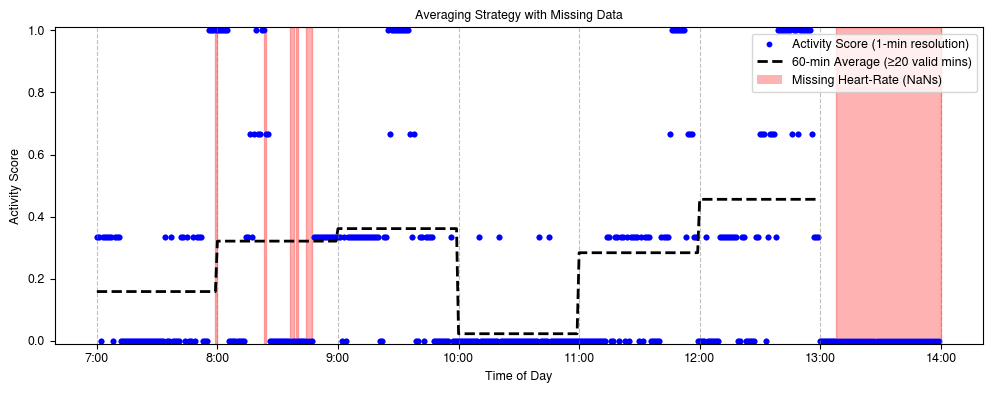

In [113]:
from matplotlib.patches import Patch

def mean_nan(y, thres=20):
    """
    Compute the mean of y ignoring NaNs, only if at least `thres` non-NaN values are present.
    """    
    return np.nanmean(y) if np.sum(~np.isnan(y)) >= thres else np.nan

# Extract 7am to 12pm (e.g. 660 to 1080 minutes)
day = 2
arr = df[df.patient_count == 450].iloc[:, 2:].values[day, 660:1080]

# Identify NaN locations
nan_idx = np.isnan(arr)

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 4))

# Plot missing regions as shaded areas
in_nan = False
for i in range(len(nan_idx)):
    if nan_idx[i] and not in_nan:
        start = i
        in_nan = True
    elif not nan_idx[i] and in_nan:
        end = i
        ax.axvspan(start, end, color='red', alpha=0.3)
        in_nan = False
if in_nan:
    ax.axvspan(start, len(nan_idx), color='red', alpha=0.3)

# Plot original activity score
ax.scatter(np.arange(len(arr)), arr, label='Activity Score (1-min resolution)', color='blue', s=10)

# fill in missing values to showcase how heart-rate is relevant
arr2 = arr.copy()
arr2[nan_idx] = 0
arr2[np.where(nan_idx[:90])[0]] = 1
ax.scatter(np.arange(len(arr)), arr2, color='blue', s=10)

# Compute and plot 60-min windowed averages (repeated for each minute)
vals = []
for i in range(len(arr) // 60):
    avg = mean_nan(arr[i * 60: (i + 1) * 60])
    vals += list(np.full(60, avg))
ax.plot(vals, label='60-min Average (≥20 valid mins)', color='k', linewidth=2, linestyle='--')

# X-tick settings: every 60 min, label as clock time
xticks = np.arange(0, len(arr)+1, 60)
xtick_labels = ['7:00', '8:00', '9:00', '10:00', '11:00', '12:00','13:00', '14:00']
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Add dashed grid lines
ax.grid(True, axis='x', linestyle='--', color='gray', alpha=0.5)

# Labels, title, legend
ax.set_title('Averaging Strategy with Missing Data')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Activity Score')
ax.set_ylim(-0.01, 1.01)

missing_patch = Patch(facecolor='red', alpha=0.3, label='Missing Heart-Rate (NaNs)')
ax.legend(handles=ax.get_legend_handles_labels()[0]+[missing_patch], loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig("./figs/averaging_strategy_plot.jpg", dpi=300, bbox_inches='tight')

# Activity 2D map
Please clarify the meaning of the numbers at the top of the subplots in Figure 3. For example, what does "69.1/95" represent for the first panel (ID.0)? The interpretation of these visualizations across individuals is challenging because the y-axis scales are not fixed. This creates a misleading visual comparison, as a participant with only a few valid days (e.g., ID 18) appears to have their data overrepresented in their subplot compared to participants with more data. To ensure an accurate and comparable visual representation, I recommend fixing the y-axis to a consistent scale across all subplots. This will prevent the overrepresentation of participants with fewer data points and allow for a more meaningful interpretation of the overall figure.

##### Functions

In [93]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

def classify_subject(valid_h, adherence, is_control):
    if valid_h < 480:
        return "Excluded", "#808080"  # Gray
    if is_control:
        return "Healthy Control", "#2ca02c"  # Green
    if adherence > 90:
        return "Tuning Cohort", "#1f77b4"  # Blue
    return "Evaluation Cohort", "#ff7f0e"  # Orange

def create_clinical_atlas(subject_list, output_pdf):
    cols, rows = 4, 4
    imgs_per_page = cols * rows
    
    # 1. Get dimensions and calculate scaling
    sample = Image.open(subject_list[0]['path'])
    w, h = sample.size
    
    # Define Font Sizes (scaled to image width)
    # If image width is ~1000px, 60-80 is good for headers
    header_size = int(w * 0.08) 
    legend_size = int(w * 0.05)
    banner_size = int(w * 0.04)
    
    try:
        # Standard path on most Linux clusters
        font_path = "/usr/share/fonts/dejavu/DejaVuSans-Bold.ttf"
        f_large = ImageFont.truetype(font_path, header_size)
        f_med = ImageFont.truetype(font_path, legend_size)
        f_small = ImageFont.truetype(font_path, banner_size)
    except:
        f_large = f_med = f_small = ImageFont.load_default()

    # 2. Layout Constants
    header_h = int(h * 0.4)    # Space for Title/Legend at top
    banner_h = int(h * 0.08)   # Space for the color strip above each plot
    padding = 40               # Extra space between plots
    
    page_w = (w + padding) * cols
    page_h = (h + banner_h + padding) * rows + header_h
    
    pages = []
    total_pages = (len(subject_list) + imgs_per_page - 1) // imgs_per_page

    for i in range(0, len(subject_list), imgs_per_page):
        batch = subject_list[i : i + imgs_per_page]
        page_canvas = Image.new('RGB', (page_w, page_h), "white")
        draw = ImageDraw.Draw(page_canvas)
        
        # --- HEADER SECTION ---
        page_num = (i // imgs_per_page) + 1
        draw.text((50, 40), "Supplementary Data 1: Participant Activity Atlas", fill="black", font=f_large)
        draw.text((50, 40 + header_size), f"Page {page_num} of {total_pages} | Groups: Tuning > Evaluation > Controls", fill="gray", font=f_med)
        
        # --- LEGEND ---
        legend_items = [("Tuning", "#1f77b4"), ("Evaluation", "#ff7f0e"), 
                        ("Controls", "#2ca02c"), ("Excluded", "#808080")]
        for j, (text, color) in enumerate(legend_items):
            x_start = 50 + (j * (page_w // 4))
            y_start = header_h - 100
            draw.rectangle([x_start, y_start, x_start + 60, y_start + 60], fill=color)
            draw.text((x_start + 80, y_start), text, fill="black", font=f_med)

        # --- GRID SECTION ---
        for index, item in enumerate(batch):
            img = Image.open(item['path'])
            
            # Calculate position
            col = index % cols
            row = index // cols
            
            x_pos = col * (w + padding) + 20
            y_pos = row * (h + banner_h + padding) + header_h
            
            # 1. Draw the Color Banner (above the image)
            draw.rectangle([x_pos, y_pos, x_pos + w, y_pos + banner_h], fill=item['color'])
            
            # 2. Draw the Status Text inside the banner
            draw.text((x_pos + 10, y_pos + 5), item['status'].upper(), fill="white", font=f_small)
            
            # 3. Paste the Plot (below the banner)
            page_canvas.paste(img, (x_pos, y_pos + banner_h))
            
        pages.append(page_canvas)

    # Save
    pages[0].save(output_pdf, save_all=True, append_images=pages[1:])
    print(f"Professional Atlas saved: {output_pdf}")            


##### Make images

In [84]:
# Configuration
FIXED_MAX = 106
OUTLIER_THRESHOLD = 200

for cohort_type in ['case', 'ctrl']:
    data = load(cohort=cohort_type)
    is_ctrl = (cohort_type == 'ctrl')

    for pid in range(len(data['data'])):
        raw_data = data['data'][pid][:, :, dim]
        actual_hours = len(raw_data.reshape(-1))
        actual_days = actual_hours/24
        valid_total = np.sum(~np.isnan(raw_data))
        adherence = (valid_total / actual_hours) * 100
        
        fig, ax = plt.subplots(figsize=(5, 8))
        
        # Square-root scale to highlight low-activity patterns
        norm = colors.PowerNorm(gamma=0.5, vmin=0, vmax=1.0)
        current_data = np.ma.masked_invalid(raw_data)
        ax.set_facecolor('#f0f0f0') # Light gray for missing data
        
        im = ax.pcolormesh(current_data, cmap='viridis', norm=norm, shading='auto')
    
        # --- Y-AXIS LOGIC ---
        if actual_days > OUTLIER_THRESHOLD:
            # For outliers, we show the first 106 days but label the truncation
            ax.set_ylim(0, FIXED_MAX)
            ax.text(0.5, 0.03, f"Note: Plot truncated at {FIXED_MAX} of {actual_days} days", 
                    transform=ax.transAxes, color='red', ha='center', fontsize=9, fontweight='bold')
            # Draw a zigzag or break line at the bottom
            ax.hlines(y=FIXED_MAX-1, xmin=0, xmax=24, colors='red', linestyles='--')
        else:
            ax.set_ylim(0, FIXED_MAX)
        
        ax.invert_yaxis()
    
        # --- DESCRIPTIVE TITLE ---
        # Example: Subject 0 | 95 Days Total | 72% Adherence
        title_str = (f"Subject {pid:03d} | Total Duration: {int(actual_hours)}h\n"
                     f"Valid: {int(valid_total)}h ({adherence:.1f}% completeness)")
        ax.set_title(title_str, fontsize=9, pad=10) #, fontweight='bold')
        
        # Labeling
        ax.set_ylabel("Study Day (Standardized Scale)")
        ax.set_xlabel("Hour of Day")
        ax.set_xticks([0, 6, 12, 18, 24])
        ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '24:00'])
    
        plt.colorbar(im, ax=ax, label='Physical Activity Score (PAS)', fraction=0.046, pad=0.04)
        
        plt.savefig(f'./figs/subject_heatmaps/{cohort_type}_{pid}.jpg', dpi=200, bbox_inches='tight')
        plt.close(fig)    
    print('finished', cohort_type)
print('done with images')

cases 159
finished case
cases 71
finished ctrl
done with images


##### Combine

In [85]:
# --- Process Both Cohorts ---
all_subject_files = []

for cohort_type in ['case', 'ctrl']:
    data = load(cohort=cohort_type)
    is_ctrl = (cohort_type == 'ctrl')
    
    for pid in range(len(data['data'])):
        raw_data = data['data'][pid][:, :, 0]
        actual_hours = raw_data.size
        valid_h = np.sum(~np.isnan(raw_data))
        adherence = (valid_h / actual_hours) * 100
        
        status, color = classify_subject(valid_h, adherence, is_ctrl)
        
        # Only include if you want the excluded ones in the atlas too, 
        # otherwise wrap in 'if status != "Excluded":'
        path = f'./figs/subject_heatmaps/{cohort_type}_{pid}.jpg'
        
        if os.path.exists(path):
            all_subject_files.append({
                'pid': pid,
                'cohort': cohort_type,
                'status': status,
                'color': color,
                'valid_h': valid_h,
                'path': path
            })
    
# --- Final Sort: By Group Priority, then by Valid Hours ---
# Priority: Tuning > Evaluation > Controls > Excluded
priority = {"Tuning Cohort": 0, "Evaluation Cohort": 1, "Healthy Control": 2, "Excluded": 3}
all_subject_files.sort(key=lambda x: (priority[x['status']], -x['valid_h']))
print('done with sorting')

output_pdf = './figs/Supp_Data_1_Activity_Atlas.pdf'
create_clinical_atlas(all_subject_files, output_pdf)

cases 159
cases 71
done with sorting


In [94]:
!bjobs

       JOBID       USER     JOB_NAME   STAT      QUEUE  FROM_HOST    EXEC_HOST   SUBMIT_TIME    START_TIME  TIME_LEFT
   226047428   jegmij01      jupyter    RUN    express    li04e02    4*lg07c05  Jan 16 10:09  Jan 16 10:09     5:53 L


# Visualize time series predictions (need to load actual predictions first)

In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,roc_auc_score

# --- Original time-series plot ---

t_warm = 96 * 3 * 5 # ignore first 5 days for metrics
t0, t1 = 300 + t_warm, 372 + t_warm # visualize in plot
#shift = False # 1/3 error reduction by shifting

fig = plt.figure(figsize=(7, 5))
xtime = np.arange(len(res.loc[t0:t1]['y_true'])) + 18
plt.plot(xtime, res.loc[t0:t1]['y_true'],lw=1, label='Activited Score', c='k')
plt.plot(xtime, res.loc[t0:t1]['y_pred'],lw=0.,marker='o', label='Training Memory = 10 Days', c='red')
plt.plot(xtime, res2.loc[t0:t1]['y_pred'],lw=0.,marker='o', label='Training Memory = 1 Day', c='blue')
plt.xlabel('Daytime [hh:mm]')
plt.ylabel('Activity Score')
plt.legend(['True Activity Score', 'Cross-Linear with 10 Days of Training Memory', 'Cross-Linear with 1 Day of Training Memory']) 
plt.title('True vs Predicted Time-Series')
plt.grid(True)

# ticks
xticks = np.array([6,24-6,36-6,48-6,60-6, 72-6]) + 18
plt.gca().set_xticks(xticks)
xtick_labels = ['00:00', '12:00', '00:00', '12:00', '00:00','12:00']

#yticks = np.array([0,0.1,0.2,0.3])
yticks = np.array([0,0.1,0.2,0.3, 0.4])
plt.gca().set_yticks(yticks)
plt.gca().set_xticklabels(xtick_labels)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig("figures/time_series_prediction.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Compute error metrics
non_sleep = False
if non_sleep:
    # Apply warm-up offset first
    df_eval = res.iloc[t_warm:].reset_index(drop=True)    
    print('Before time filter', len(df_eval))    
    # Filter for hours between 7:00 and 22:01
    df_eval = df_eval[(df_eval['hour'] >= 7.0) & (df_eval['hour'] <= 22.0)].reset_index(drop=True)
    
else:
    df_eval = res.iloc[t_warm:].reset_index(drop=True)
yt = df_eval['y_true']
yp = df_eval['y_pred']
print('data points used', len(yt))
target = df_eval['sb'] > 0    
print('balance',target.mean())
ymax = max(max(yt), max(yp))

rmse = np.sqrt(mean_squared_error(yt, yp))
mae = mean_absolute_error(yt, yp)
corr = np.corrcoef(yt, yp)[0, 1]
auc = roc_auc_score(target, yp)

# --- Scatter plot: True vs Predicted ---
plt.figure(figsize=(7, 7))
plt.scatter(res['y_true'], res['y_pred'], alpha=0.5)
plt.xlabel('True activity')
plt.ylabel('Predicted activity')
plt.title('True vs Predicted (Scatter Plot)')
plt.xlim([0, ymax])
plt.ylim([0, ymax])

# Add diagonal dashed line
plt.plot([0, ymax], [0, ymax], 'k--', color='gray')

# Annotate RMSE and MAE
metrics_text = f'RMSE = {rmse:.3f}\nMAE = {mae:.3f}\nCorr = {corr:.3f}'
if hr: metrics_text = metrics_text + f'\nAUC = {auc:.3f}'

plt.text(0.05, 0.85, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()